In [7]:
import warnings
import logging

# Suppress DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Suppress jupyter_client warning logs
logging.getLogger("jupyter_client").setLevel(logging.ERROR)
logging.getLogger("py.warnings").setLevel(logging.ERROR)


In [8]:
import pandas as pd


critical_minerals_df = pd.read_csv('/content/critical_minerals_raw.csv')

In [11]:
import pandas as pd

# Load raw EXIM data
df = pd.read_csv("/content/critical_minerals_raw.csv")

# Basic cleaning
df["Flow"] = df["Flow"].str.strip().str.capitalize()
df["mineral"] = df["mineral"].str.strip().str.capitalize()
df["Country"] = df["Country"].str.strip()


#1. Country Concentration Dependency (Top-3 import share)

In [14]:
# Inspect available years
sorted(df["Year"].unique())
latest_year = df["Year"].max()
print(f"Latest year: {latest_year}")

Latest year: 2025


In [15]:
imports_latest = df[
    (df["Year"] == latest_year) &
    (df["Flow"] == "Import")
]


Aggregate imports by mineral & country

In [16]:
country_imports = (
    imports_latest
    .groupby(["mineral", "Country"])["Quantity"]
    .sum()
    .reset_index()
)


Compute total imports per mineral

In [17]:
total_imports = (
    country_imports
    .groupby("mineral")["Quantity"]
    .sum()
    .reset_index()
    .rename(columns={"Quantity": "total_quantity"})
)


Compute country share (%)

In [18]:
country_imports = country_imports.merge(
    total_imports,
    on="mineral",
    how="left"
)

country_imports["share_pct"] = (
    country_imports["Quantity"] /
    country_imports["total_quantity"]
) * 100


Compute Top-3 Country Concentration (FINAL METRIC)

In [19]:
top3_concentration = (
    country_imports
    .sort_values(["mineral", "share_pct"], ascending=[True, False])
    .groupby("mineral")
    .head(3)
    .groupby("mineral")["share_pct"]
    .sum()
    .reset_index()
    .rename(columns={"share_pct": "top3_import_share_pct"})
)


Assigning risk labels

In [20]:
def concentration_risk(x):
    if x > 70:
        return "High"
    elif x > 40:
        return "Medium"
    else:
        return "Low"

top3_concentration["concentration_risk"] = (
    top3_concentration["top3_import_share_pct"]
    .apply(concentration_risk)
)


In [21]:
top3_concentration.to_csv(
    "top3_country_concentration_dependency.csv",
    index=False
)

top3_concentration


,mineral,top3_import_share_pct,concentration_risk
0,Copper,57.498773,Medium
1,Graphite,85.321912,High
2,Lithium,94.871746,High


In [22]:
top5_countries = (
    country_imports
    .sort_values(["mineral", "share_pct"], ascending=[True, False])
    .groupby("mineral")
    .head(5)
)

top5_countries.to_csv("top5_import_countries_latest_year.csv", index=False)


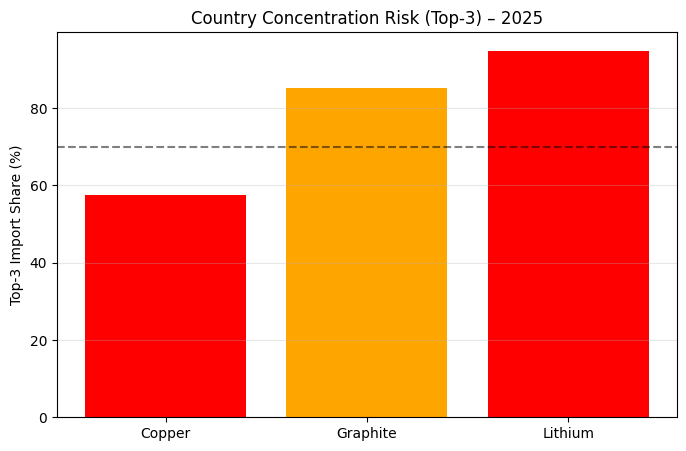

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(
    top3_concentration["mineral"],
    top3_concentration["top3_import_share_pct"],
    color=["red", "orange", "red"]
)

plt.axhline(70, linestyle="--", color="black", alpha=0.5)
plt.ylabel("Top-3 Import Share (%)")
plt.title(f"Country Concentration Risk (Top-3) – {latest_year}")
plt.grid(axis="y", alpha=0.3)
plt.show()


##Summary
The country concentration analysis reveals severe supply-side risks for critical minerals. Lithium imports are extremely concentrated, with the top three supplier countries accounting for over 90% of total imports, indicating high geopolitical and supply-chain vulnerability. Graphite also exhibits high concentration (~ 85%), while Copper shows comparatively better diversification (~57%), though still above acceptable risk thresholds. This highlights the urgent need for supplier diversification strategies, particularly for battery-critical minerals.

#2. Import Dependency Ratio

In [27]:
import pandas as pd

agg_df = pd.read_csv("/content/aggregated_df.csv")

agg_df.head()


,date,mineral,Flow,Quantity,Volume
0,2018-01-01,Copper,export,17988944.0,21.05
1,2018-01-01,Copper,import,132623287.0,525.65
2,2018-01-01,Graphite,export,12126.0,0.13
3,2018-01-01,Graphite,import,450456.0,0.59
4,2018-01-01,Lithium,export,273979.0,1.28


In [28]:
import pandas as pd

agg_df = pd.read_csv("/content/aggregated_df.csv")

# Convert date to datetime
agg_df["date"] = pd.to_datetime(agg_df["date"])

# Extract Year
agg_df["Year"] = agg_df["date"].dt.year

agg_df.head()


,date,mineral,Flow,Quantity,Volume,Year
0,2018-01-01,Copper,export,17988944.0,21.05,2018
1,2018-01-01,Copper,import,132623287.0,525.65,2018
2,2018-01-01,Graphite,export,12126.0,0.13,2018
3,2018-01-01,Graphite,import,450456.0,0.59,2018
4,2018-01-01,Lithium,export,273979.0,1.28,2018


In [29]:
agg_df["Flow"] = agg_df["Flow"].str.strip().str.capitalize()
agg_df["mineral"] = agg_df["mineral"].str.strip().str.capitalize()


ggregate monthly → yearly before dependency.

In [30]:
yearly_trade = (
    agg_df
    .groupby(["Year", "mineral", "Flow"])["Quantity"]
    .sum()
    .reset_index()
)


In [31]:
yearly_pivot = yearly_trade.pivot_table(
    index=["Year", "mineral"],
    columns="Flow",
    values="Quantity",
    fill_value=0
).reset_index()

yearly_pivot.head()


Flow,Year,mineral,Export,Import
0,2018,Copper,129575417.0,1.128994e+09
1,2018,Graphite,229599.0,2.077766e+07
2,2018,Lithium,2470051.0,6.209942e+08
3,2019,Copper,311425524.0,8.881144e+08
4,2019,Graphite,179245.0,1.547584e+07


Compute Import Dependency Ratio

In [32]:
yearly_pivot["import_dependency_ratio"] = (
    yearly_pivot["Import"] /
    (yearly_pivot["Import"] + yearly_pivot["Export"])
)

yearly_pivot["import_dependency_pct"] = (
    yearly_pivot["import_dependency_ratio"] * 100
)


Avoid partial years (like 2025 if incomplete):

In [33]:
dependency_trends = yearly_pivot[
    (yearly_pivot["Year"] >= 2018) &
    (yearly_pivot["Year"] <= 2024)
]


In [34]:
dependency_trends.to_csv(
    "import_dependency_ratio_trends.csv",
    index=False
)

dependency_trends


Flow,Year,mineral,Export,Import,import_dependency_ratio,import_dependency_pct
0,2018,Copper,129575417.0,1.128994e+09,0.897045,89.704547
1,2018,Graphite,229599.0,2.077766e+07,0.989070,98.907049
2,2018,Lithium,2470051.0,6.209942e+08,0.996038,99.603818
3,2019,Copper,311425524.0,8.881144e+08,0.740379,74.037920
4,2019,Graphite,179245.0,1.547584e+07,0.988550,98.855036
5,2019,Lithium,2622024.0,6.712207e+08,0.996109,99.610885
6,2020,Copper,128164834.0,6.421160e+08,0.833613,83.361285
7,2020,Graphite,366607.0,1.986044e+07,0.981875,98.187541
8,2020,Lithium,2212254.0,5.320321e+08,0.995859,99.585910
9,2021,Copper,101550073.0,9.932211e+08,0.907241,90.724082


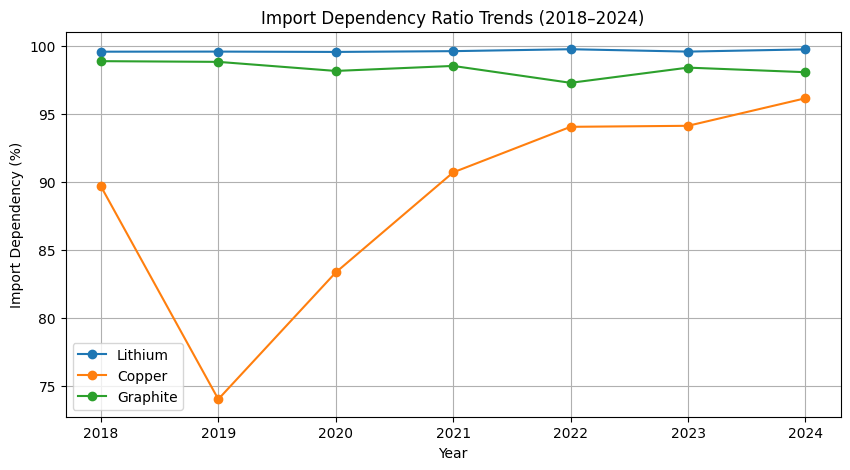

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

for mineral in ["Lithium", "Copper", "Graphite"]:
    subset = dependency_trends[
        dependency_trends["mineral"] == mineral
    ]
    plt.plot(
        subset["Year"],
        subset["import_dependency_pct"],
        marker="o",
        label=mineral
    )

plt.title("Import Dependency Ratio Trends (2018–2024)")
plt.ylabel("Import Dependency (%)")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
plt.show()


##Summary
Lithium shows an almost complete import dependency (nearly 99-100%) throughout 2018–2024, highlighting India’s near-total reliance on foreign sources for lithium supply.
Graphite also exhibits persistently high dependency (~97–99%), indicating limited domestic production despite its strategic importance for batteries and steelmaking.
Copper displays comparatively lower but rising dependency, increasing from ~74% in 2019 to over ~96% by 2024, suggesting growing import reliance and weakening domestic self-sufficiency over time.

#3. Trade Dependency / Trade Balance Ratio

In [36]:
# agg_df already loaded
agg_df.head()


,date,mineral,Flow,Quantity,Volume,Year
0,2018-01-01,Copper,Export,17988944.0,21.05,2018
1,2018-01-01,Copper,Import,132623287.0,525.65,2018
2,2018-01-01,Graphite,Export,12126.0,0.13,2018
3,2018-01-01,Graphite,Import,450456.0,0.59,2018
4,2018-01-01,Lithium,Export,273979.0,1.28,2018


In [37]:
yearly_trade = (
    agg_df
    .groupby(["Year", "mineral", "Flow"])["Quantity"]
    .sum()
    .reset_index()
)


In [38]:
trade_balance_df = yearly_trade.pivot_table(
    index=["Year", "mineral"],
    columns="Flow",
    values="Quantity",
    fill_value=0
).reset_index()

trade_balance_df.head()


Flow,Year,mineral,Export,Import
0,2018,Copper,129575417.0,1.128994e+09
1,2018,Graphite,229599.0,2.077766e+07
2,2018,Lithium,2470051.0,6.209942e+08
3,2019,Copper,311425524.0,8.881144e+08
4,2019,Graphite,179245.0,1.547584e+07


Compute Trade Balance

In [39]:
trade_balance_df["trade_balance"] = (
    trade_balance_df["Export"] - trade_balance_df["Import"]
)


Trade Dependency Ratio

In [40]:
trade_balance_df["trade_dependency_ratio"] = (
    (trade_balance_df["Import"] - trade_balance_df["Export"]) /
    (trade_balance_df["Import"] + trade_balance_df["Export"])
)


Close to 1 → fully import-dependent

Close to 0 → balanced

Negative → export-dominant

In [ ]:
trade_balance_df = trade_balance_df[
    (trade_balance_df["Year"] >= 2018) &
    (trade_balance_df["Year"] <= 2024)
]


Filter valid years

In [41]:
trade_balance_df = trade_balance_df[
    (trade_balance_df["Year"] >= 2018) &
    (trade_balance_df["Year"] <= 2024)
]


In [42]:
trade_balance_df.to_csv(
    "trade_balance_dependency.csv",
    index=False
)


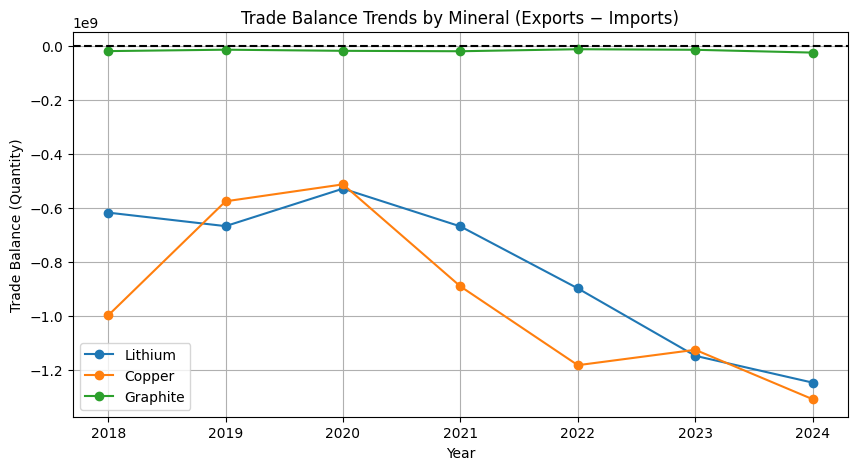

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

for mineral in ["Lithium", "Copper", "Graphite"]:
    subset = trade_balance_df[
        trade_balance_df["mineral"] == mineral
    ]
    plt.plot(
        subset["Year"],
        subset["trade_balance"],
        marker="o",
        label=mineral
    )

plt.axhline(0, color="black", linestyle="--")
plt.title("Trade Balance Trends by Mineral (Exports − Imports)")
plt.ylabel("Trade Balance (Quantity)")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
plt.show()


##Summary
The trade balance trends indicate that India remains a net importer of all three minerals—Lithium, Copper, and Graphite—throughout 2018–2024. Lithium shows a consistently large and widening trade deficit, reinforcing its classification as a high-risk critical mineral. Copper’s trade balance deteriorates significantly after 2020, indicating increasing import reliance despite some domestic production capacity. Graphite, while having a comparatively smaller absolute trade deficit, remains persistently negative, confirming sustained dependence on external supply.

#India is not only dependent, but that dependency is economically worsening.

#📊 Integrated Critical Mineral Risk Assessment
While individual metrics such as import dependency, trade balance, and country concentration provide partial insights into mineral security, a holistic assessment requires integrating all dimensions into a unified framework.

This section presents a Risk Matrix that combines historical dependency indicators with future forecast risks to identify minerals posing the highest strategic vulnerability to India.

In [44]:
import pandas as pd

In [45]:
risk_matrix = pd.DataFrame({
    "Mineral": ["Lithium", "Graphite", "Copper"],

    "Import Dependency": ["Very High", "High", "High"],
    "Trade Balance Risk": ["Very High", "Moderate–High", "High"],
    "Country Concentration": ["Very High", "High", "Moderate"],
    "Forecast Risk": ["High", "Medium", "Medium"]
})


convert risk levels to scores

In [46]:
risk_score_map = {
    "Very High": 3,
    "High": 2,
    "Moderate–High": 2,
    "Medium": 1,
    "Moderate": 1
}

for col in ["Import Dependency", "Trade Balance Risk", "Country Concentration", "Forecast Risk"]:
    risk_matrix[col + " Score"] = risk_matrix[col].map(risk_score_map)

risk_matrix["Total Risk Score"] = (
    risk_matrix["Import Dependency Score"] +
    risk_matrix["Trade Balance Risk Score"] +
    risk_matrix["Country Concentration Score"] +
    risk_matrix["Forecast Risk Score"]
)

risk_matrix


,Mineral,Import Dependency,Trade Balance Risk,Country Concentration,Forecast Risk,Import Dependency Score,Trade Balance Risk Score,Country Concentration Score,Forecast Risk Score,Total Risk Score
0,Lithium,Very High,Very High,Very High,High,3,3,3,2,11
1,Graphite,High,Moderate–High,High,Medium,2,2,2,1,7
2,Copper,High,High,Moderate,Medium,2,2,1,1,6


Overall Risk Category

In [47]:
def overall_risk(score):
    if score >= 10:
        return "CRITICAL"
    elif score >= 7:
        return "HIGH"
    else:
        return "MEDIUM"

risk_matrix["Overall Risk Category"] = risk_matrix["Total Risk Score"].apply(overall_risk)

risk_matrix


,Mineral,Import Dependency,Trade Balance Risk,Country Concentration,Forecast Risk,Import Dependency Score,Trade Balance Risk Score,Country Concentration Score,Forecast Risk Score,Total Risk Score,Overall Risk Category
0,Lithium,Very High,Very High,Very High,High,3,3,3,2,11,CRITICAL
1,Graphite,High,Moderate–High,High,Medium,2,2,2,1,7,HIGH
2,Copper,High,High,Moderate,Medium,2,2,1,1,6,MEDIUM


In [48]:
risk_matrix.to_csv("critical_mineral_risk_matrix.csv", index=False)


##🧠 Risk Matrix Interpretation
The integrated risk matrix highlights Lithium as the most critical mineral for India, scoring the maximum risk due to near-total import dependency, extreme supplier concentration, and rapidly growing future demand.

Graphite emerges as a high-risk mineral driven by sustained import reliance and concentrated sourcing, while Copper, despite relatively better supplier diversification, shows increasing vulnerability due to a worsening trade balance and volatile future demand.

These results emphasize the urgent need for differentiated policy interventions across minerals based on their risk profiles.

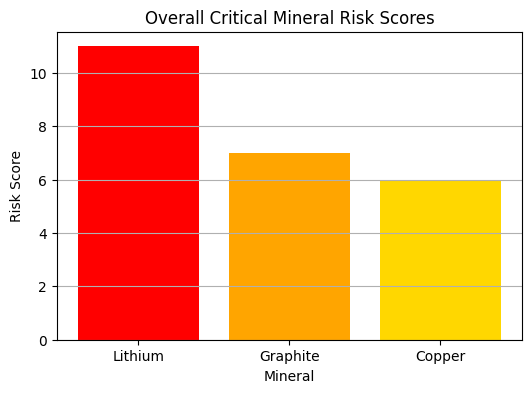

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(
    risk_matrix["Mineral"],
    risk_matrix["Total Risk Score"],
    color=["red", "orange", "gold"]
)

plt.title("Overall Critical Mineral Risk Scores")
plt.ylabel("Risk Score")
plt.xlabel("Mineral")
plt.grid(axis="y")
plt.show()


In [50]:
risk_matrix[["Mineral", "Overall Risk Category"]]


,Mineral,Overall Risk Category
0,Lithium,CRITICAL
1,Graphite,HIGH
2,Copper,MEDIUM


Apply ANOVA (Analysis of Variance) to compare trade performance across different mineral categories, time periods, or trading partners.

In [63]:
import pandas as pd

# Load data
df = pd.read_csv("/content/aggregated_df.csv")

# Convert date
df["date"] = pd.to_datetime(df["date"])

# CLEAN BOTH COLUMNS PROPERLY
df["Flow"] = df["Flow"].astype(str).str.strip().str.lower()
df["mineral"] = df["mineral"].astype(str).str.strip().str.capitalize()

# Verify what values exist (important debug)
print("Unique Flow values:", df["Flow"].unique())
print("Unique mineral values:", df["mineral"].unique())

# Filter imports
imports_df = df[df["Flow"] == "import"]

# Extract quantities
lithium_imports  = imports_df[imports_df["mineral"] == "Lithium"]["Quantity"].dropna()
copper_imports   = imports_df[imports_df["mineral"] == "Copper"]["Quantity"].dropna()
graphite_imports = imports_df[imports_df["mineral"] == "Graphite"]["Quantity"].dropna()

# Check lengths
print(
    "Lithium:", len(lithium_imports),
    "Copper:", len(copper_imports),
    "Graphite:", len(graphite_imports)
)


Unique Flow values: ['export' 'import']
Unique mineral values: ['Copper' 'Graphite' 'Lithium']
Lithium: 96 Copper: 96 Graphite: 96


In [64]:
from scipy.stats import f_oneway

f_stat, p_value = f_oneway(
    lithium_imports,
    copper_imports,
    graphite_imports
)

print(f"F-statistic: {f_stat:.2f}")
print(f"P-value: {p_value:.6f}")


F-statistic: 218.78
P-value: 0.000000


##ANOVA Analysis (Imports)
A one-way ANOVA was conducted to compare monthly import quantities of Lithium, Copper, and Graphite. The test yielded a statistically significant result (F = 218.78, p < 0.001), indicating that average import volumes differ substantially across minerals. This confirms that each mineral exhibits distinct trade dynamics and risk characteristics, validating the need for mineral-specific forecasting and dependency assessment.

#Strategic Insights & Recommendations

##Strategic Recommendations

The combined analysis of import dependency, trade balance trends, supplier concentration, and forecasted demand highlights distinct risk profiles across the three minerals, requiring differentiated policy responses rather than a one-size-fits-all approach.

Lithium emerges as a critical-risk mineral with near-total import dependence, extreme supplier concentration, and strong projected demand growth. This makes lithium supply highly vulnerable to geopolitical disruptions. India should prioritize long-term overseas asset acquisition, strategic partnerships with resource-rich countries, and accelerated domestic exploration under the National Critical Minerals Mission.

Graphite presents a high-risk profile driven by sustained import reliance and concentrated sourcing, despite relatively stable demand growth. Policy focus should be placed on supplier diversification, development of synthetic and recycled graphite capabilities, and incentives for domestic processing to reduce exposure to external shocks.

Copper, while historically less import-dependent, shows a clear deterioration in trade balance and rising dependency in recent years. Given copper’s importance across infrastructure, power, and renewable energy sectors, strengthening domestic mining, refining capacity, and recycling ecosystems would be more effective than import substitution alone.

Overall, the findings suggest that India’s mineral security strategy must integrate forecast-led demand planning, supplier diversification, and domestic capacity building, with priority allocation of resources toward minerals exhibiting both high current dependency and strong future demand growth.